# IP Address Geolocation & Distance Normalization  

## 1. Data Loading  
- Loaded the main dataset from an Excel file containing normalized network data.  
- Imported an external IP address dataset (`ipData`), which was created using **[ip-api.com](https://ip-api.com/)**.  
- Dropped unnecessary columns (`message`) from `ipData`.  

## 2. Processing IP Geolocation Data  
- Renamed IP dataset columns for clarity (`country → ip_country`, `lat → ip_lat`, `lon → ip_lon`, `query → ipAddress`).  
- Replaced missing values with default values (`0` for numerical fields, `"Unknown"` for failed lookups).  
- Dropped the `status` column after processing.  
- Merged the enriched IP metadata with the main dataset using `ipAddress`.  

## 3. Computing **Haversine Distance**  
- Implemented the **Haversine formula**, which calculates the great-circle distance between two points on a sphere using latitude and longitude.  
- The Earth's radius is assumed to be **6371 km** for accurate calculations.  
- Applied the formula to compute the distance between:  
  - **GPS coordinates** (`latitude`, `longitude` from the device)  
  - **IP-based coordinates** (`ip_lat`, `ip_lon` from the IP geolocation lookup)  
- The computed `haversine_distance_km` represents the difference between **device-reported location** and **IP-estimated location**.  

## 4. Normalization of Haversine Distances  
- Applied **StandardScaler** separately to GPS and IP-based distances:  
  - **GPS-derived distances (`location_type == 1`)** were normalized separately.  
  - **IP-derived distances (`location_type == 2`)** were normalized separately.  
- This distinction was necessary because **IP-based geolocation is less accurate** than GPS.  
- The `normalized_distance` column was computed to make the values comparable across different scales.  

## 5. Exporting Processed Data  
- Extracted `normalized_distance` values into a new CSV file (`feature_7.csv`) for further analysis.  

---

### Key Insights  
- The **Haversine formula** provides an accurate way to measure the discrepancy between GPS-based and IP-based locations.  
- **IP geolocation is inherently less precise**, which is why separate normalization was applied to avoid skewing comparisons.  
- Future enhancements could include **assigning confidence scores** to distances based on data reliability (e.g., Wi-Fi IPs vs. mobile IPs).  


In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [12]:
df = pd.read_excel(r"C:\Users\Tanmay\V-Patrol\work\CombinedCountryData_2.0-IPv4_Cleaned.xlsx",sheet_name="normalized_file123")

In [13]:
ipData = pd.read_csv(r"C:\Users\Tanmay\V-Patrol\work\uniqueIPs.csv")
ipData.drop(columns=["message"],inplace=True)

In [14]:
IPsData = ipData.rename(columns={"country": "ip_country", "lat": "ip_lat", "lon": "ip_lon", "query": "ipAddress"})
IPsData.fillna(0,inplace=True)
IPsData.iloc[IPsData["status"]=="fail",1] = "Unknown"
IPsData.drop("status",axis=1,inplace=True)

In [15]:
df1_updated = df.merge(IPsData, on="ipAddress", how="left")

In [16]:
from math import radians, sin, cos, sqrt, atan2
# Faster Haversine Formula for distance computation
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c  # Distance in km

df1_updated.sort_values(by=["deviceIfa", "reqTimeConverted"], inplace=True)
df1_updated["haversine_distance_km"] = df1_updated.apply(
    lambda row: haversine(row["latitude"], row["longitude"], row["ip_lat"], row["ip_lon"]),
    axis=1
)

# Separate GPS and IP data
gps_mask = df1_updated["location_type"] == 1
ip_mask = df1_updated["location_type"] == 2

# Initialize scalers
gps_scaler = StandardScaler()
ip_scaler = StandardScaler()

# Fit and transform GPS distances
df1_updated.loc[gps_mask, "normalized_distance"] = gps_scaler.fit_transform(
    df1_updated.loc[gps_mask, "haversine_distance_km"].values.reshape(-1, 1)
)

# Fit and transform IP distances
df1_updated.loc[ip_mask, "normalized_distance"] = ip_scaler.fit_transform(
    df1_updated.loc[ip_mask, "haversine_distance_km"].values.reshape(-1, 1)
)

In [17]:
df1_updated.sort_index(inplace=True)

In [18]:
dfTocsv = df1_updated["normalized_distance"]
dfTocsv.shape

(121585,)

In [19]:
# dfTocsv.to_csv(r"C:\Users\tanmay\V-Patrol\featureEngineering\feature_7.csv")

In [20]:
# Function to calculate IQR and identify outliers
def find_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))]
    return outliers

# Find outliers for GPS data
gps_outliers = find_outliers(df1_updated[gps_mask]["haversine_distance_km"])
print(f"Number of GPS outliers: {len(gps_outliers)}")

# Find outliers for IP data
ip_outliers = find_outliers(df1_updated[ip_mask]["haversine_distance_km"])
print(f"Number of IP outliers: {len(ip_outliers)}")

C:\Users\Tanmay\AppData\Local\Temp\ipykernel_1200\1531188958.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gps_outliers = find_outliers(df1_updated[gps_mask]["haversine_distance_km"])
C:\Users\Tanmay\AppData\Local\Temp\ipykernel_1200\1531188958.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ip_outliers = find_outliers(df1_updated[ip_mask]["haversine_distance_km"])


Number of GPS outliers: 23640
Number of IP outliers: 2262


# Visualization and Insights

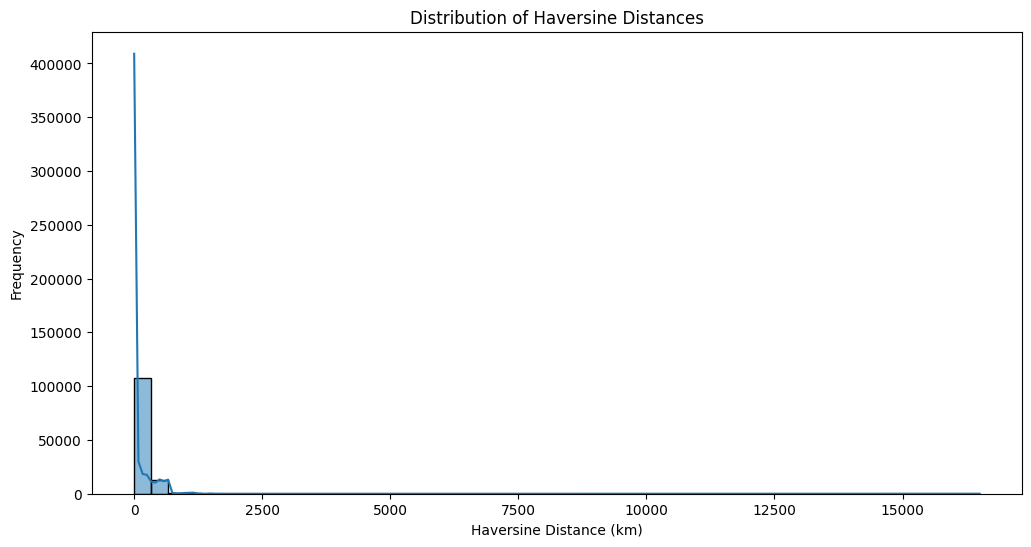

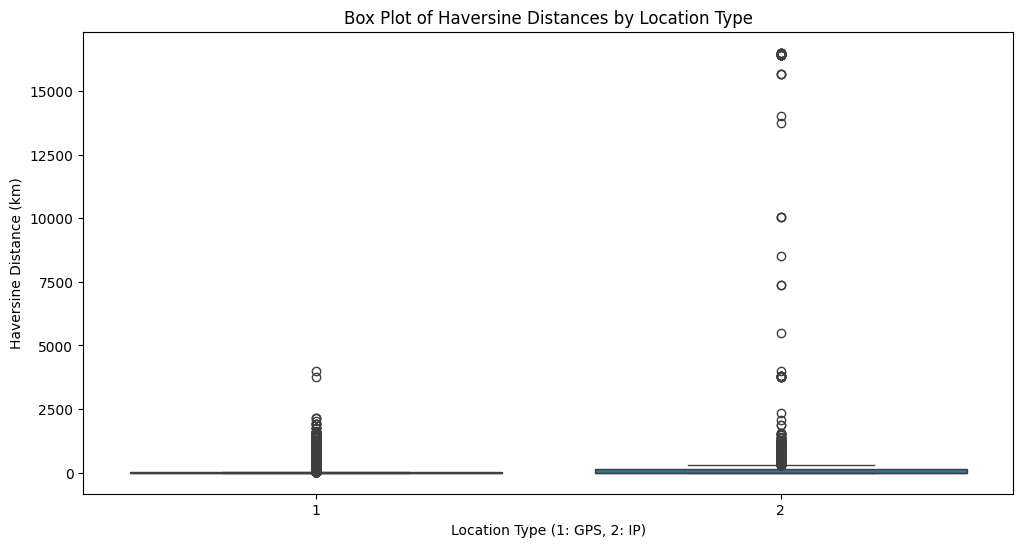

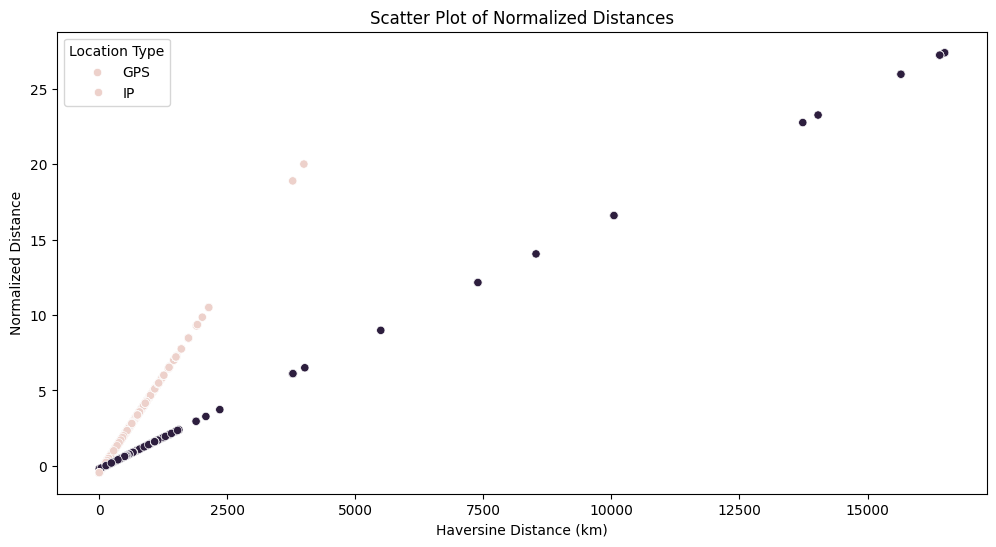

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of Haversine Distances
plt.figure(figsize=(12, 6))
sns.histplot(df1_updated['haversine_distance_km'], bins=50, kde=True)
plt.title('Distribution of Haversine Distances')
plt.xlabel('Haversine Distance (km)')
plt.ylabel('Frequency')
plt.show()

# Box Plot of Haversine Distances
plt.figure(figsize=(12, 6))
sns.boxplot(x='location_type', y='haversine_distance_km', data=df1_updated)
plt.title('Box Plot of Haversine Distances by Location Type')
plt.xlabel('Location Type (1: GPS, 2: IP)')
plt.ylabel('Haversine Distance (km)')
plt.show()

# Scatter Plot of Normalized Distances
plt.figure(figsize=(12, 6))
sns.scatterplot(x='haversine_distance_km', y='normalized_distance', hue='location_type', data=df1_updated)
plt.title('Scatter Plot of Normalized Distances')
plt.xlabel('Haversine Distance (km)')
plt.ylabel('Normalized Distance')
plt.legend(title='Location Type', labels=['GPS', 'IP'])
plt.show()

## **Insights from the Haversine Distance Analysis:**


#### **1. High Haversine Distances Indicate Potential Threats**
- **Observation**:  
  The distribution of Haversine distances shows a long tail extending to **15,000 km**, with non-trivial frequencies beyond 10,000 km.  
- **Abnormality Insight**:  
  - Distances >10,000 km between GPS and IP locations are **geographically impossible** for legitimate user activity (e.g., a device in New York cannot physically connect via an IP in Jakarta within seconds).  
  - Likely scenarios:  
    - **Spoofed GPS coordinates** (e.g., fake location apps).  
    - **IP masking** (e.g., VPNs/proxies used to bypass geo-restrictions or hide C2 servers).  
    - **Account takeover** (e.g., stolen credentials used from a distant location).  

#### **2. IP Geolocation Shows Higher Volatility (Box Plot Insights)**  
- **Observation**:  
  - The box plot suggests IP-based distances (`location_type=2`) have a **wider spread** (higher IQR) compared to GPS.  
  - Outliers in IP distances are more frequent (e.g., values near 15,000 km).  
- **Abnormality Insight**:  
  - IP geolocation is inherently less accurate, but extreme outliers indicate:  
    - **Bulletproof hosting** (e.g., attackers using IPs from unregulated regions).  
    - **Proxy chaining** (e.g., traffic routed through multiple countries to evade detection).  
  - GPS outliers, while fewer, could signal **GPS spoofing** (e.g., fraudulent ad clicks).  

#### **3. Normalized Distance Outliers (Scatter Plot Insights)**  
- **Observation**:  
  - After normalization, some GPS/IP distances deviate significantly from the mean (e.g., normalized values >3σ).  
- **Abnormality Insight**:  
  - **GPS outliers**: Devices with sudden location jumps (e.g., "impossible travel" from Paris to Sydney in minutes).  
  - **IP outliers**: IPs consistently mismatched with GPS (e.g., a device in Bangladesh always connecting via Colombian IPs).  
  - These patterns align with **botnet activity** or **data exfiltration** (e.g., rerouting traffic to obscure destinations).  

### **Summary**  
The data reveals **systematic abuse of geolocation mismatches**, with clusters of spoofed IPs/GPS coordinates and high-risk geographic patterns.